In [2]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from numpy import clip
from torch.autograd import Variable
import torch
from torch import Tensor
from torch.optim import SGD, Adam
from IPython.display import clear_output
import ipywidgets as widgets
from ipywidgets import interact
from torch.nn.functional import softplus
w = widgets.IntText()
%matplotlib inline
%run utils.py
%load_ext Cython
from numpy.random import permutation
M, N = 40, 140

In [2]:
# %%cython
# import numpy as np
# cimport numpy as np

# cdef int M = 40
# cdef int N = 140
# DTYPE = np.int
# ctypedef np.int_t DTYPE_t


# def random_path(int sx, int sy, int tx, int ty, int L):
#     cdef int hor_dir = np.sign(tx - sx)
#     cdef int ver_dir = np.sign(ty - sy)
#     cdef np.ndarray[DTYPE_t, ndim=3] paths = np.zeros([M, N, L], dtype=DTYPE)
#     paths[sx,sy,:] = 1
#     cdef int X = np.abs(tx - sx) 
#     cdef int Y = np.abs(ty - sy) 
#     cdef np.ndarray[DTYPE_t, ndim=1] nullpth = np.zeros(X+Y, dtype=DTYPE)
#     nullpth[:X] = 1
    
#     cdef np.ndarray[DTYPE_t, ndim=1] path = np.zeros(X+Y, dtype=DTYPE)
#     cdef np.ndarray[DTYPE_t, ndim=1] x_indices = np.zeros(X+Y, dtype=DTYPE)
#     cdef np.ndarray[DTYPE_t, ndim=1] y_indices = np.zeros(X+Y, dtype=DTYPE)
#     cdef int l

#     for l in range(L):
#         path = np.random.permutation(nullpth)
#         x_indices = path.cumsum() * hor_dir + sx
#         y_indices = (1-path).cumsum() * ver_dir + sy
#         paths[x_indices, y_indices, l] = 1
#     return paths

In [25]:
%%cython 
import numpy as np
cimport numpy as np

cdef int M = 40
cdef int N = 140
DTYPE = int
ctypedef np.int_t DTYPE_t


def random_path(int sx, int sy, int tx, int ty, int L):
    cdef int hor_dir, ver_dir, X, Y, XY
    
    hor_dir = (tx - sx) > 0
    ver_dir = (ty - sy) > 0
    
    cdef np.ndarray[DTYPE_t, ndim=3] paths = np.zeros([M, N, L], dtype=DTYPE)
    paths[sx,sy,:] = 1
    
    X = abs(tx - sx) 
    Y = abs(ty - sy) 
    XY = X + Y
    
    cdef np.ndarray[DTYPE_t, ndim=1] path = np.zeros(X+Y, dtype=DTYPE)
    path[:X] = 1
    
    cdef int l, i, x, y

    for l in range(L):
        x, y = sx, sy
        np.random.shuffle(path)
        for i in range(XY):
            if path[i]:
                x += 2 * hor_dir - 1
            else:
                y += 2 * ver_dir - 1
            paths[x,y,l] = 1
    return paths

In [26]:
def log_sum_exp(value):
    m = torch.max(value)
    sum_exp = torch.sum(torch.exp(value - m))
    return m + torch.log(sum_exp)

In [86]:
weights = Variable((10 * torch.ones((M,N))).float(), requires_grad=True)
L = 20
s2 = 10 ** 2 # sigma2 = (10 s) ** 2

In [87]:
# chunks = pd.read_csv('data/yellow_tripdata_2009-01_train_JC.csv', chunksize=100000)
# h = True
# for df in tqdm(chunks, total=93):
#     try:
#         df['sx'] = np.clip(np.round(M/10 * df['start_x'] ), 0, M-1) 
#         df['sy'] = np.clip(np.round(M/10 * df['start_y'] ), 0, N-1) 
#         df['tx'] = np.clip(np.round(M/10 * df['end_x'] ), 0, M-1) 
#         df['ty'] = np.clip(np.round(M/10 * df['end_y'] ), 0, N-1) 
#         (df.loc[(df['duration'] < 3600 * 2) & (df['duration'] > 120), 
#                ['duration','sx','sy','tx','ty']]
#          .to_csv('data/yellow_tripdata_2009-01_train_JC_40x140.csv', 
#                  mode='a', index=False, header=h))
#     except:
#         print('exception encountered')
#         continue
#     h = False

In [4]:
df = pd.read_csv('data/split/JC_week0_hour8_40x140.csv') # monday 8am

In [89]:
optimizer = Adam([weights], lr = 0.05)
num_epochs = 5
def loss_fn(paths, t):
    weighted_paths = (Variable(Tensor(paths.astype(float)))
                              * weights.unsqueeze(-1))
    weight_sums = weighted_paths.sum(dim=0).sum(dim=0)
    first = (-1/(2 * L * s2) * (t - weight_sums).pow(2).sum())
    second = - weighted_paths.sum() / L
    third = - log_sum_exp(-weight_sums)
    loss = -(first + second + third)
    return loss 
avg_loss = []

In [90]:
pbar = tqdm(total=len(df))
losses = []
def update(row):
    pbar.update(1)
    paths = random_path(int(row['sx']), int(row['sy']), 
                        int(row['tx']), int(row['ty']), L)
    t = float(row['duration'])
    loss = loss_fn(paths, t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.data[0])

A Jupyter Widget

In [91]:
for i in range(10):
    df.apply(update,axis=1)

KeyboardInterrupt: 

In [64]:
@interact(x=w)
def plot(x):
    plt.figure(figsize=(10,10))
    plt.imshow(torch.nn.functional.softplus(weights).data.numpy().T, 
               clim=(10,30), cmap='bwr', origin='lower')
    plt.savefig('{}.png'.format(x))
    plt.show()

A Jupyter Widget

In [31]:
with tqdm(total=num_epochs * len(df)) as pbar:
    total_loss = 0
    for epoch in range(num_epochs):
        for _, row in df.iterrows():
            pbar.update(1)
            paths = random_path(int(row['sx']), int(row['sy']), 
                                int(row['tx']), int(row['ty']), L)
            t = float(row['duration'])
            loss = loss_fn(paths, t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.data[0]
            if pbar.n % 100 == 0:
                avg_loss.append(total_loss/pbar.n)
                w.value += 1
#                 clear_output(wait=True)
#             if pbar.n % 500 == 0:
#                 w.value += 1    

A Jupyter Widget

KeyboardInterrupt: 

(-0.5, 39.5, -0.5, 139.5)

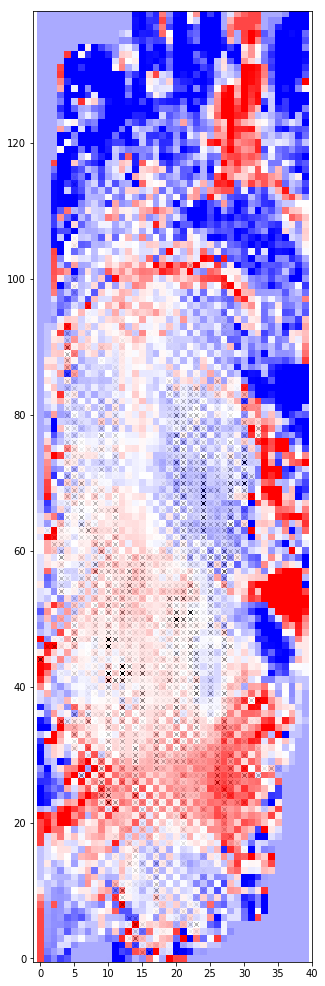

In [44]:
plt.figure(figsize=(10/2,140/8))
plt.imshow(np.load('results/week0_hour0_1.npy').T, origin='lower',
           clim=(0,30), cmap='bwr')
plt.plot(df['sx'], df['sy'], 'kx', alpha=0.0050)
plt.axis('equal')
